# Assignment 4 - Digital signal processing and analysis

Course "Data processing and Visualization", IE500417, NTNU.

https://www.ntnu.edu/studies/courses/IE500417

**Note (as usual): plagiarism is strictly forbidden! You should never copy any source code from other students. If you use any code written by others (except the standards libraries: NumPy, SciPy, Pandas, etc), provide a reference.**

**If the teachers see that your work is mostly copy+paste from online code snippets, the grade can be reduced.**

**If a case of plagiarism is detected, it will be reported to the administration.**

## Task description

In this assignment, you will practice digital signal processing (in a rather basic form, there will be no advanced DSP methods). You will work with two signals
simultaneously. As it sometimes happens, the two signals are not synchronized: they are sampled at
different time moments and with different sampling rate. You will have to resample and synchronize
them so that both signals have the same sample timestamps. You will do some analysis of the signals
and visualize them using line charts.

## Submission details (as usual)

The assignment must be handed in on Blackboard. The following must be handed in:
1. Report in PDF or HTML format describing the results of this assignment. Preferably, it is generated from the Jupyter notebook you used (Hint: In Jupyter: File > Download as > HTML). Alternatively (if you use plain Python or other tools), prepare a readable report that contains figures and source code snippets necessary to understand your work.
2. Source code that you used to generate the results. This could be the the Jupyter notebook file, python source files, Matlab files, etc.

Deadlines and grading information on Blackboard.

In [47]:
import pandas as pd
import numpy as np
from pathlib import Path
import math
import warnings
import os
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from scipy.fft import fft, fftfreq
from scipy.signal import resample
from scipy.interpolate import interp1d

DATA_DIR = Path("./data")

In [48]:
#unity functions

# Plots freq domain of graph
def plot_freq(amp, freq):
    fig = go.Figure([
        go.Scatter(x=freq, y=amp, line=go.scatter.Line(dash="solid", width=1, color="pink"), name="Signal"),
    ])
    fig.layout.template = "plotly_dark"
    fig.update_layout(
        title = dict(
            font = dict(
                size = 20
            ),
            text = "Frequency Domain"
        ),
        height = 600,
        yaxis_title="Amplitude",
        xaxis_title="Frequency"
    )
    fig.update_xaxes(
        tickangle = -45,
    )
    fig.show()
    
# Plots original and resampled data
def plot_signals(signal, org):
    signal = signal.copy()
    signal["time"] = signal["time"]
    
    org_signal = org.copy()
    org_signal["time"] = org_signal["time"]

    fig = go.Figure([
        go.Scatter(x=org_signal['time'], y=org_signal['value'], line=go.scatter.Line(dash="solid", width=1, color="pink"), name="Original"),
        go.Scatter(x=signal['time'], y=signal['value'], line=go.scatter.Line(dash="dot", width=1, color="cyan"), name="Resampled")
    ])
    fig.layout.template = "plotly_dark"
    fig.update_layout(
        title = dict(
            font = dict(
                size = 20
            ),
            text = "Signal Values"
        ),
        height = 600,
        yaxis_title="Value",
        xaxis_title="Sample time"
    )
    fig.update_xaxes(
        tickangle = -45,
    )
    fig.show()

## Part 1: Understanding the signals (25%)

**Step 1.1: Load the two signals from CSV files: s1.csv and s2.csv.**

In [49]:
# Your code here
sig_1 = pd.read_csv(DATA_DIR / "s1.csv")
sig_2 = pd.read_csv(DATA_DIR / "s2.csv")

**Step 1.2: Do a quick analysis of what data you got: column names of each signal and number of rows.**

In [50]:
# Your code here
sig_1 = sig_1.rename(columns={"s1": "value"}) #renaming it to value for consistency
sig_1.head()

,time,value
0,2017-08-29 10:30:00.000,15.12
1,2017-08-29 10:30:00.010,15.01
2,2017-08-29 10:30:00.020,14.51
3,2017-08-29 10:30:00.030,14.94
4,2017-08-29 10:30:00.040,14.96


In [51]:
sig_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    10000 non-null  object 
 1   value   10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [52]:
sig_1.describe()

,value
count,10000.000000
mean,82.165242
std,38.120285
min,13.420000
25%,49.183750
50%,76.800000
75%,106.825000
max,201.240000


In [53]:
sig_2 = sig_2.rename(columns={"s2": "value"}) #renaming for consistency
sig_2.head()

,time,value
0,2017-08-29 10:30:00.000,241.17
1,2017-08-29 10:30:00.190,238.04
2,2017-08-29 10:30:00.400,239.95
3,2017-08-29 10:30:00.520,242.19
4,2017-08-29 10:30:00.700,244.66


In [54]:
sig_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 810 entries, 0 to 809
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    810 non-null    object 
 1   value   810 non-null    float64
dtypes: float64(1), object(1)
memory usage: 12.8+ KB


In [55]:
sig_2.describe()

,value
count,810.000000
mean,254.646198
std,32.345325
min,182.840000
25%,227.762500
50%,256.930000
75%,282.846250
max,312.000000


**Step 1.3: One of the signals is sampled at even frequency, another is not. Find out which is the nonuniformly
sampled signal. Store it in variable `signal_x`. Store the the uniformly sampled signal in variable `signal_u`.**

Note: "find out" here means **"write code that finds out"**. If you will manually assign the `signal_u` and `signal_x` variables, you won't get points for this step. The reason - manual assignment is not flexible. If the dataset changes, your remaining notebook calculations will be wrong suddenly. Flexible code that finds the necessary signals would work even if we would swap the s1.csv and s2.csv files.

In [56]:
# Your code here
def to_datetime(datatime_str):
    return datetime.strptime(datatime_str, '%Y-%m-%d %H:%M:%S.%f')

def is_sampling_freq_even(sig):
    num_of_samples = sig["time"].shape[0]
    assert num_of_samples >= 3, "Need at least 3 points to check"
    time_df = sig["time"].copy().apply(to_datetime)
    time_delta = time_df.diff(1)[1:]
    return (time_delta[1] == time_delta).all()

signal_x = sig_2 if is_sampling_freq_even(sig_1) else sig_1
signal_u = sig_2 if signal_x is not sig_2 else sig_1

**Step 1.4. Plot the two signals in a line chart:**

* Both lines in a single chart
* Add a legend with label for each signal
* Signal U should be Green dashed line with line width=2
* Signal X should be Blue solid line with line width=1.
* Chart should have a title, font size = 20

A reference showing approximately how it could look:

<img src="https://user-images.githubusercontent.com/19551058/196664575-e07310df-48b1-4b9d-92f9-57dd8549d0d3.PNG">

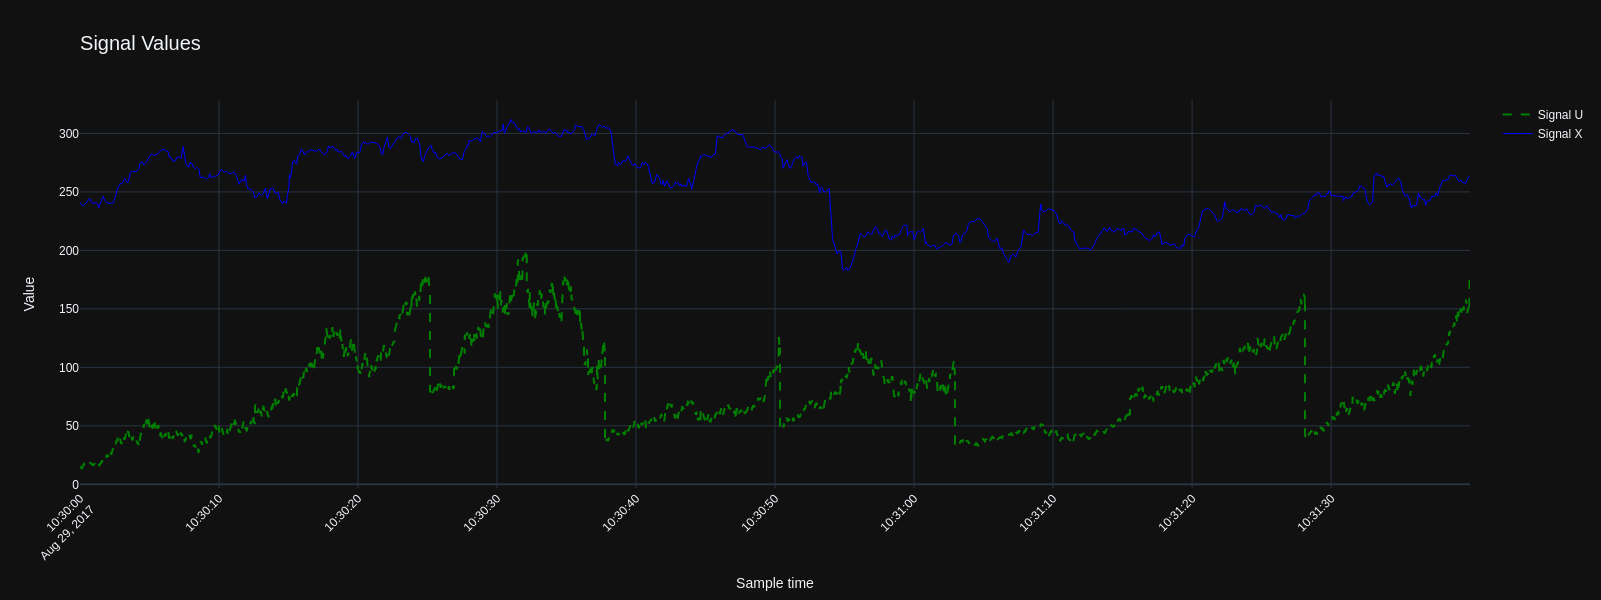

In [57]:
# Your code here
signal_X_converted = signal_x.copy()
signal_X_converted["time"] = signal_X_converted["time"].apply(to_datetime)

signal_U_converted = signal_u.copy()
signal_U_converted["time"] = signal_U_converted["time"].apply(to_datetime)

fig = go.Figure([
    go.Scatter(x=signal_U_converted['time'], y=signal_U_converted['value'], line=go.scatter.Line(dash="dash", width=2, color="green"), name="Signal U"),
    go.Scatter(x=signal_X_converted['time'], y=signal_X_converted['value'], line=go.scatter.Line(dash="solid", width=1, color="blue"), name="Signal X")
])
fig.layout.template = "plotly_dark"
fig.update_layout(
    title = dict(
        font = dict(
            size = 20
        ),
        text = "Signal Values"
    ),
    height = 600,
    yaxis_title="Value",
    xaxis_title="Sample time"
)
fig.update_xaxes(
    tickangle = -45,
)
fig.show()

**Step 1.5: Find out the sampling frequency of Signal U, save it in variable `f_u`.**

In [58]:
# Your code here
time_per_sample = (signal_U_converted['time'][1] - signal_U_converted['time'][0]).total_seconds()

f_u = 1/ time_per_sample

**Step 1.6: Find out which are the highest frequencies used in Signal U. Save the highest frequency in variable `b_u`, having Hz as units.**

Hint: use Fourier transform, and find max frequency having a significant amplitude. There may be many frequencies with tiny amplitudes. Use some threshold to filter these out.

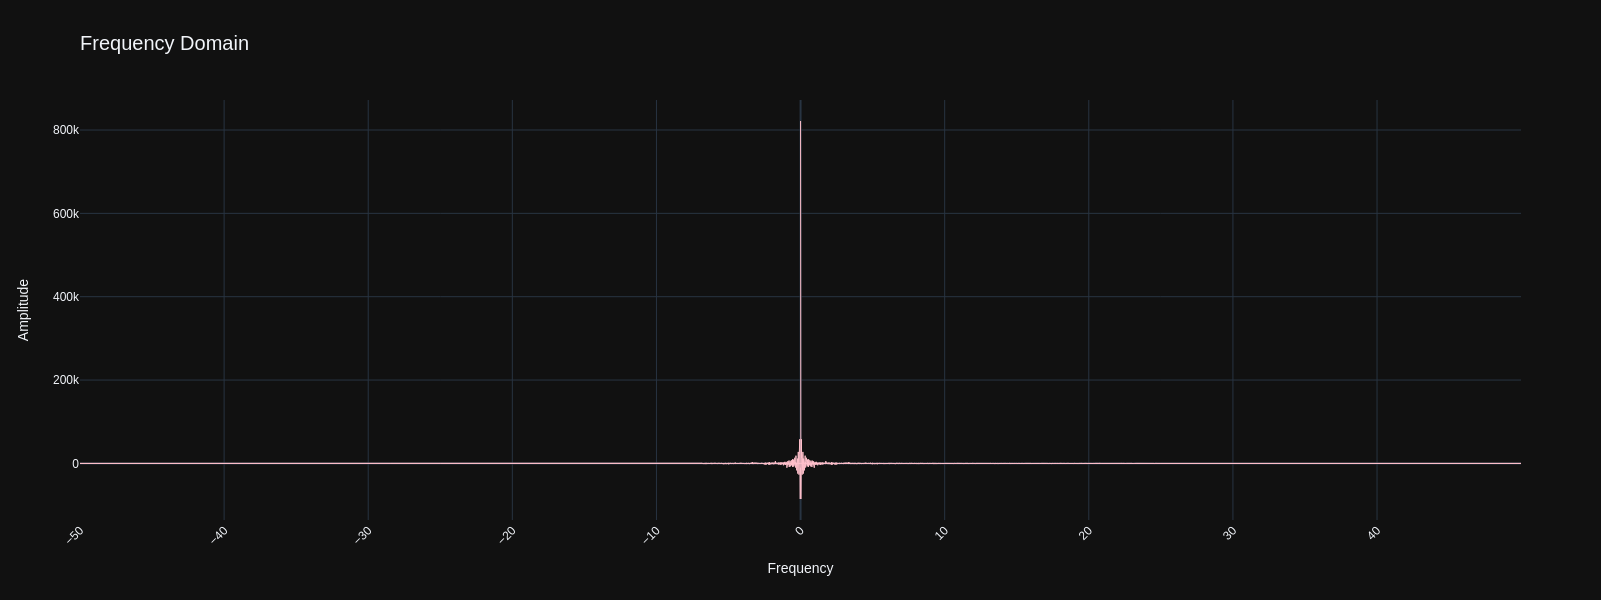

In [59]:
# Your code here
num_samples = signal_U_converted['value'].shape[0]
np_array = signal_U_converted['value'].to_numpy()

# Amplitude threshold
AMPLITUDE_THRESHOLD = 20e3

# Amplitude
yf = fft(np_array)

# Frequency
xf = fftfreq(num_samples, time_per_sample)
max_f = float('-inf')

plot_freq(yf.real, xf)

for idx in range(0, len(xf)):
    if(yf[idx] < AMPLITUDE_THRESHOLD):
        continue
    else:
        max_f = max( max_f, xf[idx] )

b_u = max_f

**Step 1.7: Find out the minimum frequency at which Signal U should have been sampled to still contain all the information in the signal. Save it in variable `fs_u`.**

Hint: Nyquist-Shannon theorem

In [60]:
# Your code here

# The theory says the sampling freq should be more than twice the highest freq in the signal
fs_u = 2 * b_u

**Step 1.8: Calculate, how many % of space is wasted by storing too many samples for Signal U. I.e., if we would resample in the Signal U at a sampling rate `fs_u`, how many samples would we store, and how much that is in relation to the number of samples in the CSV file?**

**If it is 0, why?**

P.S. Don't worry about Signal X – the sampling system for it was designed by careless engineers who did not know about Nyquist-Shannon's sampling theorem. Therefore, the sampling of Signal X is not proper. But we work with what we have.

In [61]:
# Your code here
num_samples = signal_U_converted['value'].shape[0]
time_duration_in_seconds = (signal_U_converted['time'].max() - signal_U_converted['time'].min()).total_seconds()
optimal_num_samples = time_duration_in_seconds * fs_u

print(f"Space wasted: {(num_samples - optimal_num_samples) / num_samples}%")

Space wasted: 0.99680032%


## Part 2: Synchronizing the signals – resampling (25%)

Note: whenever you modify something for the signals, it is suggested to store the modifierd signal in another variable. Keep the original one intact. You may later want to compare the two. 

**Step 2.1: Decimate (down-sample) the Signal U to 10Hz, store it in variable `su_resampled`:**

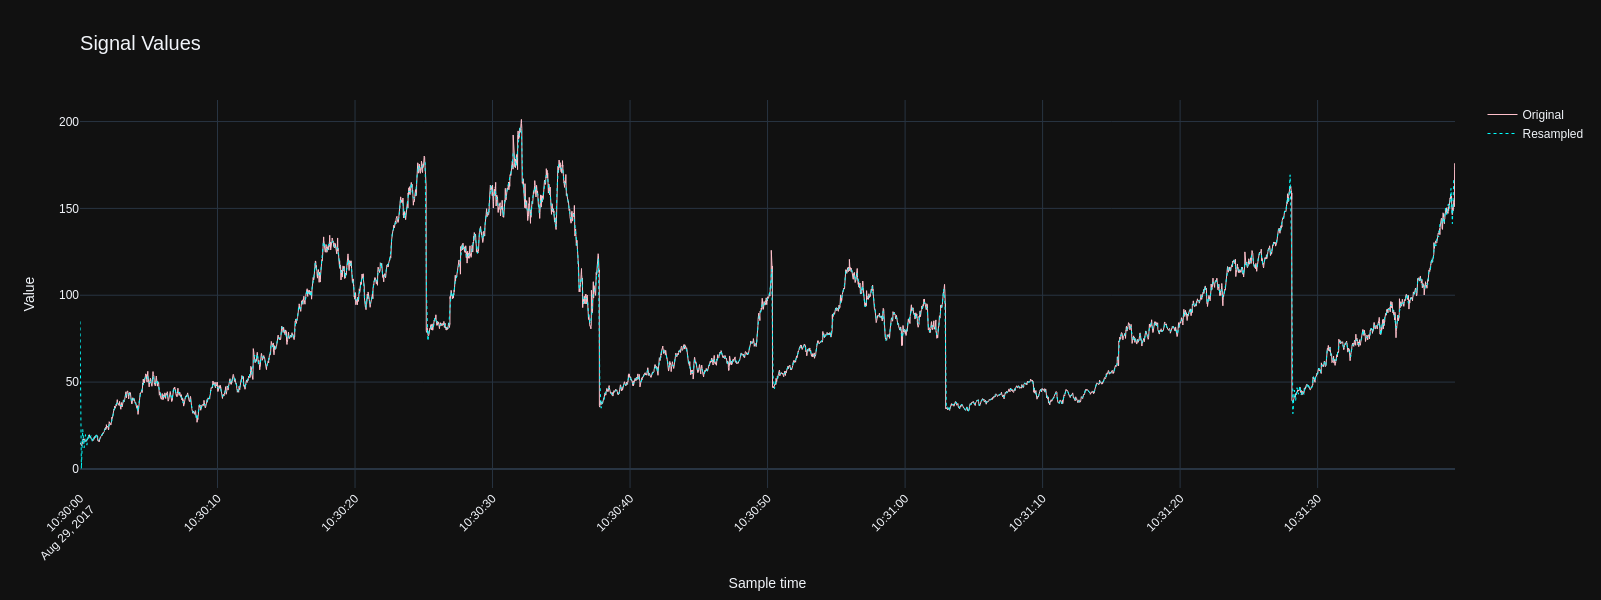

In [62]:
# Your code here
num_samples_in_10hz = round(time_duration_in_seconds * 10)

su_resampled_intermediate = resample(signal_U_converted['value'], num_samples_in_10hz, signal_U_converted['time'])

# Plotting resampled signal
plot_signals(su_resampled, signal_U_converted)

su_resampled = pd.DataFrame(data={"value": su_resampled_intermediate[0], "time": su_resampled_intermediate[1]})

**Step 2.2: Explain - why is the resampled signal not containing the same information as the original signal (i.e., what information is lost?)**

**--- YOUR ANSWER HERE ---**

From now on, in all the places whare you need to do something with Signal U, **use the resampled version: `su_resampled`.**

**Step 2.3: Synchronize Signal X with Signal U, store it in variable `sx_resampled`. I.e., if `su_resampled` is sampled at time moments t0, t1, …, tN, then resample Signal X at the same time moments: t0, t1, …, tN. This may involve several steps, 
depending on what functions/libraries you use.**

Hint: see `07-2-Resampling.ipynb` example notebook on Blackboard ().

Hint: your resulting `sx_resampled` should be 10Hz signal, not 100Hz.

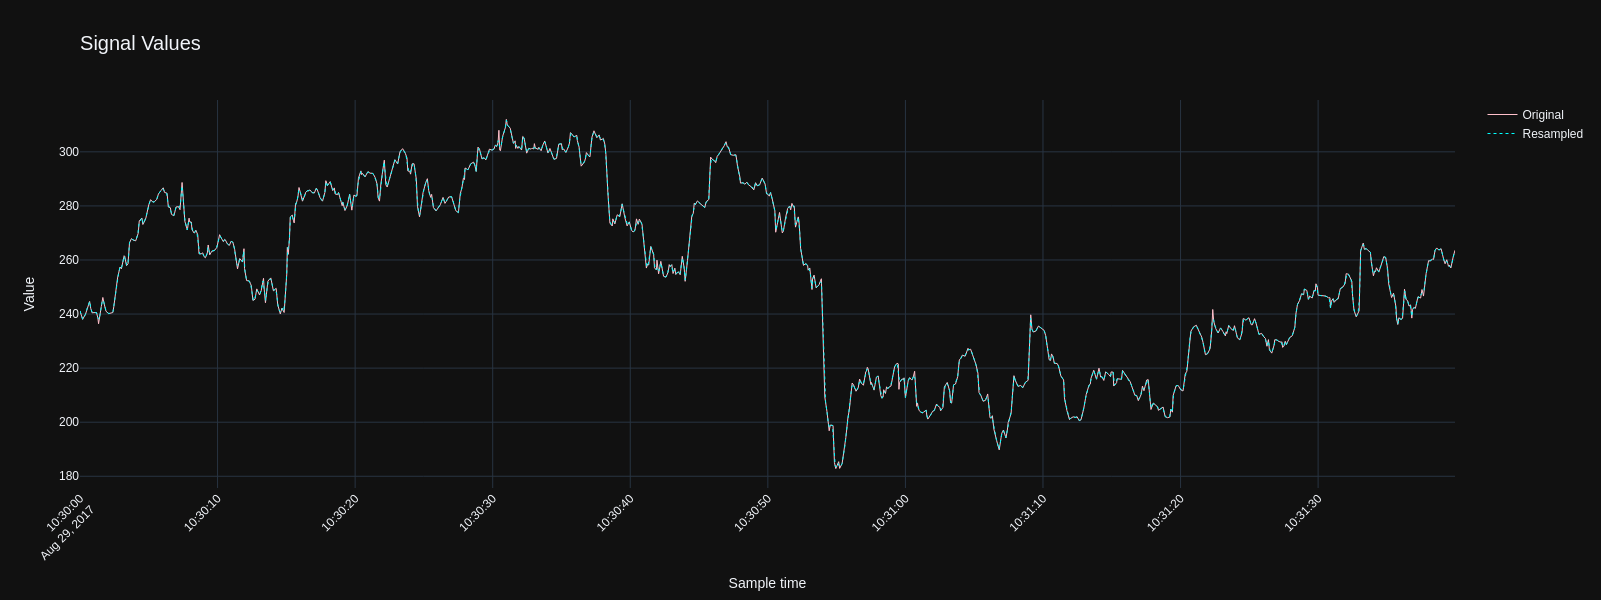

In [64]:
# Your code here
interpolation_fn = interp1d(signal_X_converted["time"].apply(datetime.timestamp), signal_X_converted["value"])
new_values = interpolation_fn(su_resampled["time"].apply(datetime.timestamp))

# Plotting the graph
plot_signals(sx_resampled, signal_X_converted)

sx_resampled = pd.DataFrame({"value": new_values, "time": su_resampled["time"]})

**Step 2.4: Check if the two signals really are synchronized – compare the timestamps, these should be
equal.**

In [74]:
# Your code here
assert sx_resampled["time"].equals(su_resampled["time"])

**Step 2.5: Take both signals and insert them into a single DataFrame object (name it `composed_data`) which has:**
* Timestamps as the index column
* Two columns named `signalX` and `signalU` containing the corresponding values (`sx_resampled` and `su_resampled`).

In [77]:
# Your code here
composed_data = pd.DataFrame({"time": sx_resampled["time"], "signalX": sx_resampled["value"], "signalU": su_resampled["value"] })

## Part 3: Find extreme values (20%)

In this part you will find extreme values in the signals. Typically, these could mean outliers, sampling errors or extreme modes of operation in the system (such as overheating of a motor).

**Step 3.1: Find Signal U values (`su_resampled`) above 170.0. Store those in variable `extreme_u_vals`.**

In [82]:
# Your code here
extreme_u_vals = su_resampled["value"][su_resampled["value"] > 170].to_numpy

**Step 3.2: Find Signal X values (`sx_resampled`) outside the range mean ± 2* StdDev. Store those in variable `ex_static_x_vals`.**

In [94]:
# Your code here
mean = sx_resampled["value"].mean()
stdDev = sx_resampled["value"].std()

ex_static_x_vals = sx_resampled["value"][ (sx_resampled["value"] > (mean + 2 * stdDev)) | (sx_resampled["value"] < (mean - 2 * stdDev)) ].to_numpy

**Step 3.3: Find Signal X values (`sx_resampled`) outside an adaptive range: 3-second moving average ± 2 * StdDev. Both the average and StdDev are calculated in a 3-second rolling window. Store the values in variable `ex_dynamic_x_vals`.**

In [69]:
# Your code here
ex_dynamic_x_vals = ...

## Part 4: Extra challenges (30%)

**Step 4.1: Plot a line chart with values, rolling mean, *normal boundaries* (mean +/- 2StdDev) and the extreme values `ex_dynamic_x_vals` that you calculated in Part 3.** Example:

<img src="https://user-images.githubusercontent.com/19551058/196664581-12a79430-0e08-4c4d-8275-c6dd7598a717.PNG">

In [70]:
# Your code here

**Step 4.2: Find segments in Signal X (`sx_resampled`) where the 10-second moving average value is increasing for a continuous period of at least two seconds.**

In [71]:
# Your code here

**Step 4.3: Plot a line chart and mark these regions (from previous step) in a different color.**

For example: show the normal line in blue color and the continuously increasing moving average segments in green. Example:

<img src="https://user-images.githubusercontent.com/19551058/196664585-51df99e4-71e4-4b0b-9807-a26f39ac1699.PNG">

In [72]:
# Your code here

## Reflection 

Please reflect on the following questions:
1. How did the assignment go? Was it easy or hard?
2. How many hours did you spend on it?
3. What was the most time-consuming part?
4. If you need to do similar things later in your professional life, how can you improve? How can you do it more efficiently?
5. Was tehre something you would expect to learn that this exercise did not include?
6. Was there something that does not make sense?

**--- YOUR ANSWERS HERE ---**